In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

### Loading data

In [4]:
column_n = ['itemId', 'category', 'subcategory', 'title', 'abstract', 'url', 'TitleEnt', 'AbstractEnt']
column_b = ['ImpressionId', 'userId', 'timestamps', 'history', 'impressions']
news_df  = pd.read_csv('data/news.tsv', sep='\t', header=None, names=column_n)
behaviors_df= pd.read_csv('data/behaviors.tsv', sep='\t', header=None, names=column_b)

In [14]:
sample_behaviors_df = behaviors_df.sample(frac=0.10, random_state=42)

### Preprocessing

In [16]:
# Delete users who don't have history     
sample_behaviors_df = sample_behaviors_df[sample_behaviors_df['history'].notna() & (sample_behaviors_df['history'] != '')]

In [23]:
# Delete news when don't title and abstract
news_df = news_df.dropna(subset=['title', 'abstract'])

In [25]:
# Remove 'U' prefix from 'user' and 'N' prefix from 'item'
sample_behaviors_df['userId'] = sample_behaviors_df['userId'].str.replace('U', '', regex=False)
news_df['itemId'] = news_df['itemId'].str.replace('N', '', regex=False)

In [27]:
# Split behaviors_df into 80% training and 20% testing
train_behaviors, test_behaviors = train_test_split(sample_behaviors_df, test_size=0.2, random_state=42)

In [29]:
# Prepare train.dat
train_data = []
for _, row in train_behaviors.iterrows():
    user_id = row['userId']
    history_items = row['history'].split()  # Assuming history items are space-separated
    for item in history_items:
        train_data.append([user_id, item, 1.0])  # Assign a binary rating of 1.0

train_df = pd.DataFrame(train_data, columns=['userId', 'itemId', 'rating'])

# Prepare test.dat
test_data = []
for _, row in test_behaviors.iterrows():
    user_id = row['userId']
    history_items = row['history'].split()
    for item in history_items:
        test_data.append([user_id, item, 1.0])  # Assign a binary rating of 1.0

test_df = pd.DataFrame(test_data, columns=['userId', 'itemId', 'rating'])


In [31]:
train_df['itemId'] = train_df['itemId'].str.replace('N', '', regex=False)
test_df['itemId'] = test_df['itemId'].str.replace('N', '', regex=False)

In [33]:
combined_df = pd.concat([train_df,test_df], axis=0, ignore_index=True)

### Mapeamento os dados

In [35]:
df=combined_df

In [37]:
df.head(2)

,userId,itemId,rating
0,22342,60615,1.0
1,22342,59742,1.0


In [39]:
n_noticias_total = len(news_df['itemId'].unique())
n_usuarios_total = len(behaviors_df['userId'].unique())
n_noticias = len(df['itemId'].unique())
n_usuarios = len(df['userId'].unique())

print("Numero de Usuarios total: ", n_usuarios_total)
print("Numero de Usuarios: ", n_usuarios)

print("Numero de noticias total: ",n_noticias_total)
print("Numero de noticias: ", n_noticias)

Numero de Usuarios total:  50000
Numero de Usuarios:  12442
Numero de noticias total:  48616
Numero de noticias:  22980


### Extrair as noticias mais populares

In [41]:
soma_interacoes_por_noticia = train_df.groupby('itemId').count()[['rating']]
soma_interacoes_por_noticia.columns = ['interactions']

map_soma = soma_interacoes_por_noticia.to_dict()['interactions']

soma_interacoes_por_noticia.head(5)

,interactions
itemId,
100,3
1000,2
10000,1
10004,2
1001,1


In [43]:
soma_interacoes_por_noticia_ordenado = soma_interacoes_por_noticia.sort_values('interactions', ascending=False)

map_id = dict(list(enumerate(soma_interacoes_por_noticia_ordenado.index)))
map_id = {v:k for k,v in map_id.items()}


soma_interacoes_por_noticia_ordenado.head(5)

,interactions
itemId,
306,1611
42620,1466
47020,1257
45794,1254
31801,1216


### 3.2 A Long Tail Curve
##### Um conceito fundamental em sistemas de recomendação é a Cauda Longa (Long Tail Curve).


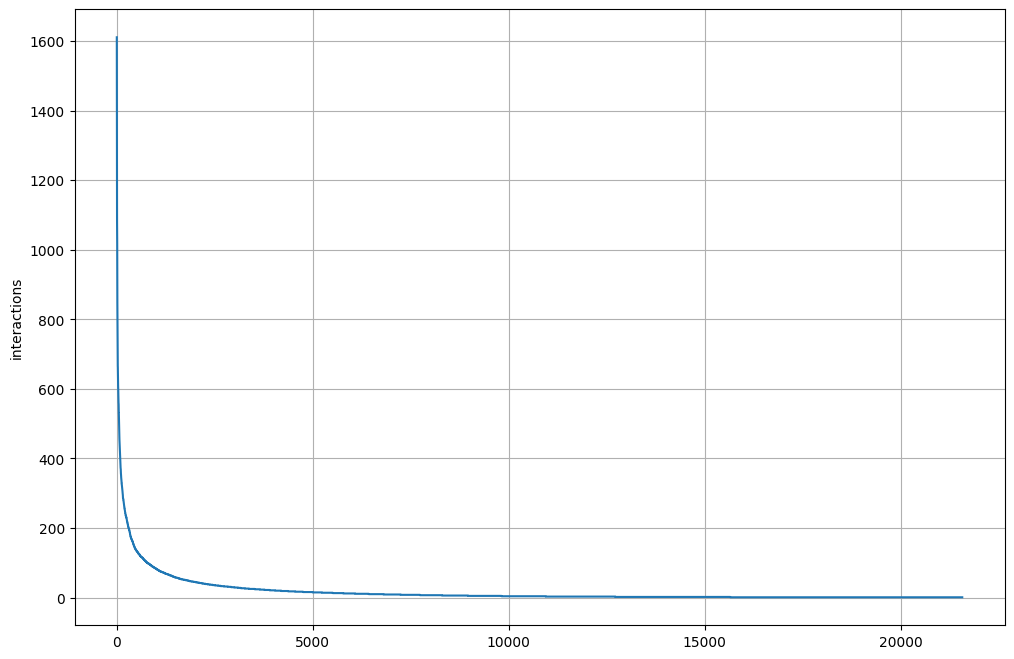

In [45]:
plt.figure(figsize=(12, 8))
sns.lineplot(
    x = [i for i in range(len(soma_interacoes_por_noticia_ordenado))],
    y = soma_interacoes_por_noticia_ordenado['interactions']
)
plt.grid()

In [ ]:
#using surprise 

In [49]:
from surprise import Reader, Dataset
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.slope_one import SlopeOne

# Define the rating scale for the Reader
reader = Reader(rating_scale=(0, 1))

# Load the training set from the DataFrame
trainset = Dataset.load_from_df(
    train_df[["userId", "itemId",'rating']], reader=reader
).build_full_trainset()

# Initialize the KNN model with cosine similarity
userknn = KNNBasic(K=10, sim_options={"user_based": True, "name": "cosine"})

# Fit the model on the trainset
userknn.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [50]:
len(test_df)

100371

In [51]:
import tqdm  # Import tqdm directly

In [60]:
new_predictions = []
prediction_user_map = {}
data_p2 = []

for user in tqdm.tqdm(test_df['userId'].unique()[:1000]):
    data = {"itemId": list(set(df["itemId"].unique()))}
    user_testset_df = pd.DataFrame(data)
    user_testset_df["rating"] = 0.0
    user_testset_df["userId"] = user
    
    testset = (
        Dataset.load_from_df(
            user_testset_df[["userId", "itemId", "rating"]],
            reader=reader,
        )
        .build_full_trainset()
        .build_testset()
    )
    predictions = sorted(
        [(pred.iid, pred.est)for pred in userknn.test(testset) if ((pred.uid == user))],
        key=lambda x: x[1],reverse=True
    )
    new_predictions.append(predictions[:10])
    prediction_user_map[user] = predictions[:10]
    
    for j in predictions[:10]:
        if j[0] in map_id:
            data_p2.append(map_id[j[0]])
    

100%|██████████| 1000/1000 [05:13<00:00,  3.19it/s]


Text(0.5, 0, 'ID Noticia')

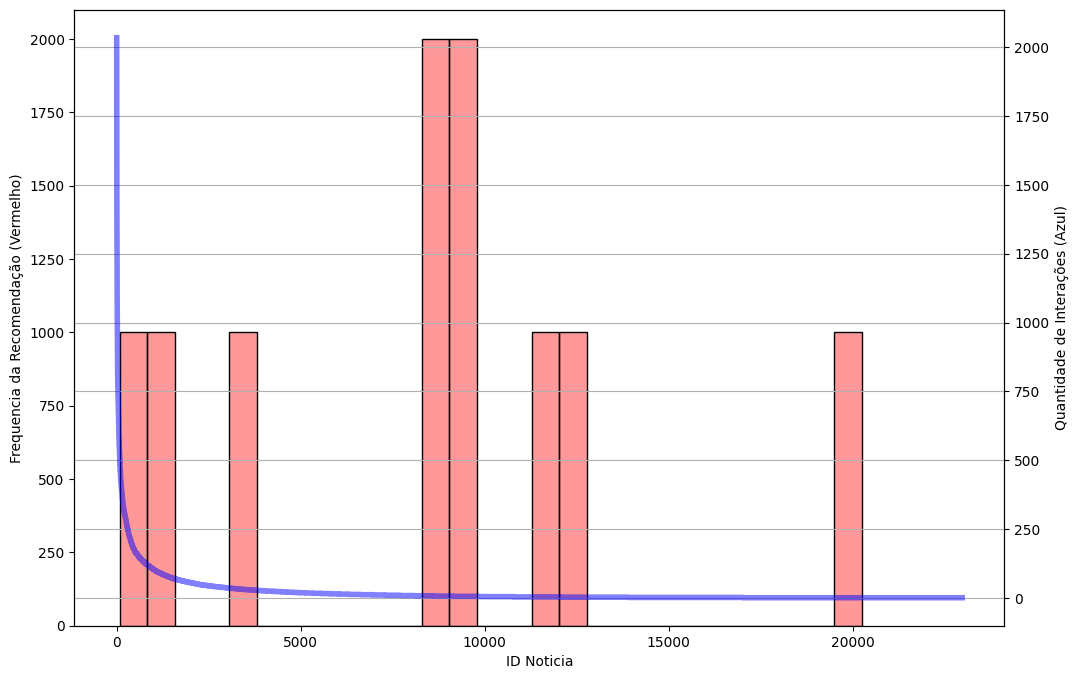

In [61]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))

g = sns.histplot(
    x = data_p2,color='red', alpha=0.4
)
plt.ylabel("Frequencia da Recomendação (Vermelho)")
plt.xlabel("ID Noticia")
ax2 = g.twinx()

plt.ylabel("Quantidade de Interações (Azul)")
sns.lineplot(
    x = [i for i in range(len(df['itemId'].unique()))],
    y=df.groupby('itemId').count().sort_values('rating', ascending=False)['rating'], ax=ax2,
    color='blue',linewidth = 4, alpha=0.5
)
plt.grid()
plt.xlabel("ID Noticia")